# Single Inverted Pendulum
First we need the model of the single inverted pendulum. Friedland works it mostly out for us in Chapter 2.

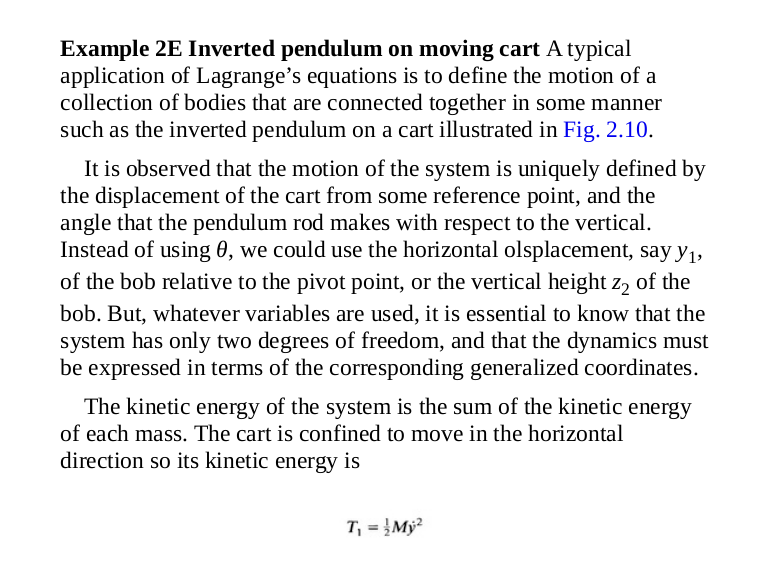

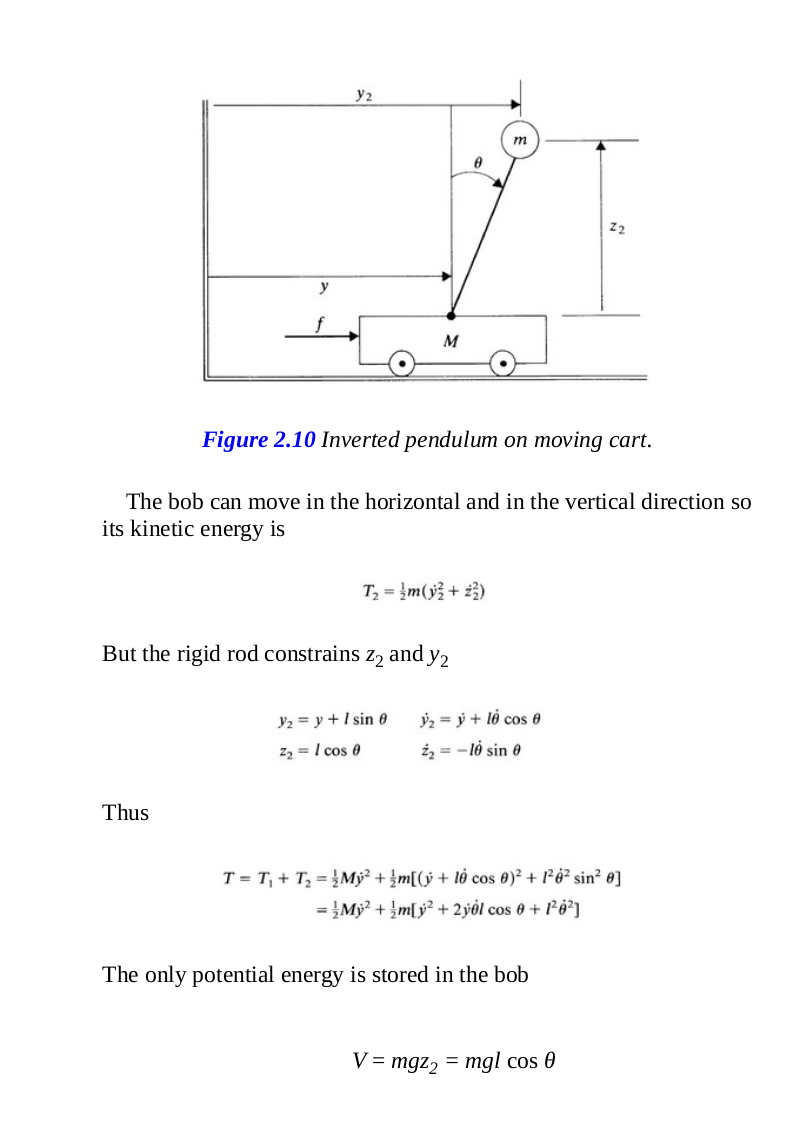

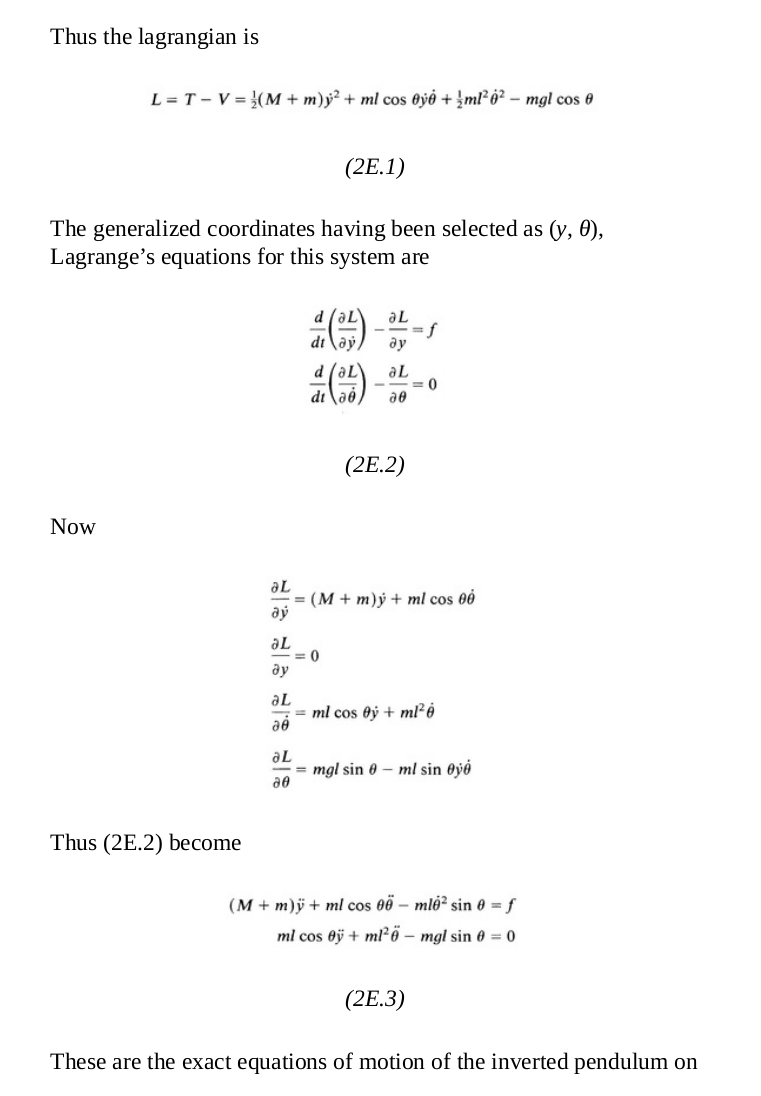

Integrating...
Done


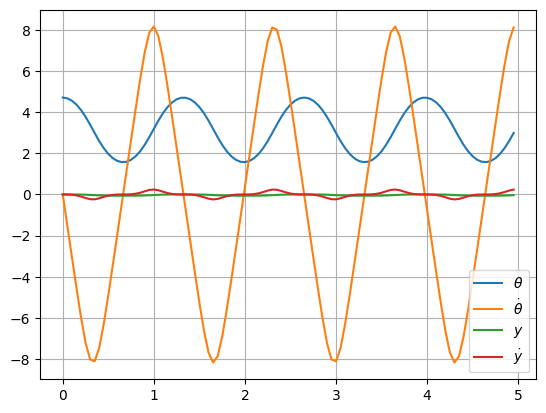

In [1]:
#-----------------------------------------------------------------------------------------------------------
#
#            This code shows how to simulate the nonlinear set of ordinary differential equations in python.
#
#-----------------------------------------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from math import pi, trunc
from numpy import sin, cos, tan

def trim(x, step):
    d = trunc(x / step)
    return step * d

# simulation time
dt = 0.05
Tmax = 5
t = np.arange(0.0, Tmax, dt)  # might need to adjust this to be compatible with the notebook

# set Pendulum Parameters
f = 0.0
# First set up the parameters for the pendulum.  I will use the values for the WWU pendulum as much as I can.
M = 0.3163 # Mass of carriage (kg)
m = 0.0318 # Mass of the long pendulum (kg)
R = 4.09 # Motor resistance (Ohms)
r = 0.0254/2  # Pulley radius (meters)
k = 0.0351 # Torque constant (Nm/A)
K = 0.0351 # Back emf constant (Vs/rad)
l = 0.323 # length of the long pendulum rod (meters)
g = 9.81  # gravity (m/s^2)
s = 1  #  -1 for hanging down; +1 for up
    
# initial conditions
th_dot = .0 		# pendulum angular velocity
th = pi/2.0 + pi	# pendulum angle (start it hanging almost down)
y = .0		# cart position
y_dot = .0		# cart velocity

# y0 = 0		# desired cart position

precision = 0.006 # 
state = np.array([th, th_dot, y, y_dot, trim(th, precision), .0])

def derivatives(state, t):
    ds = np.zeros_like(state)

    _th = state[0]
    _th_dot = state[1]
    _y = state[2]
    _y_dot = state[3]

    ds[0] = state[1]
    ds[1] = ((M+m)*g*tan(_th)-m*l*state[1]**2*sin(_th)-f)/((M+m)*l/cos(_th)-m*l*cos(_th))
    ds[2] = state[3]
    ds[3] = g*tan(_th)-l*ds[1]/cos(_th)

    return ds

print("Integrating...")
# integrate your ODE using scipy.integrate.
solution = integrate.odeint(derivatives, state, t)
print("Done")

ths = solution[:, 0]
th_dots = solution[:,1]
ys = solution[:, 2]
y_dots = solution[:,3]

plt.plot(t, ths, t, th_dots, t, ys, t, y_dots)
plt.legend([r'$\theta$', r'$\dot \theta$', r'$y$', r'$\dot y$'])
plt.grid()
plt.show()


This looks reasonable for hanging down at least.

In [2]:
# This is for the animation of the inverted pendulum nonlinear behavior.

pxs = l * sin(ths) + ys
pys = l * cos(ths)

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1.5, 1.5), ylim=(-0.5, 2))
ax.set_aspect('equal')
ax.grid()

patch = ax.add_patch(Rectangle((0, 0), 0, 0, linewidth=1, edgecolor='k', facecolor='g'))

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

cart_width = 0.3
cart_height = 0.2

def init():
    line.set_data([], [])
    time_text.set_text('')
    patch.set_xy((-cart_width/2, -cart_height/2))
    patch.set_width(cart_width)
    patch.set_height(cart_height)
    return line, time_text, patch


def animate(i):
    thisx = [ys[i], pxs[i]]
    thisy = [0, pys[i]]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    patch.set_x(ys[i] - cart_width/2)
    return line, time_text, patch

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(solution)),
                              interval=25, blit=True, init_func=init)

# Set up formatting for the movie files
print("Writing video...")
Writer = animation.writers['imagemagick']
writer = Writer(fps=25, metadata=dict(artist='Sergey Royz'), bitrate=1800)
ani.save('controlled-cart.gif', writer=writer)
plt.close()

Writing video...


![](./controlled-cart.gif)

(The nonlinear state equations, which come from (2E.3) for $\ddot y$ and $\ddot \theta$ are figured out below. )
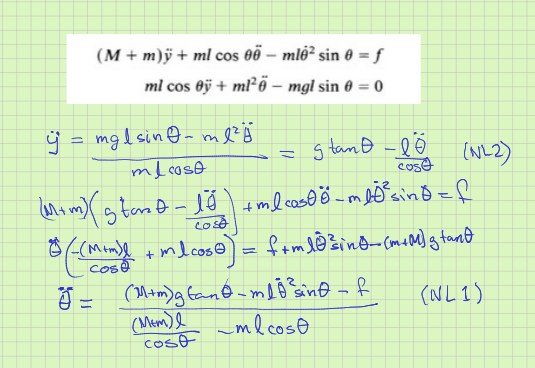

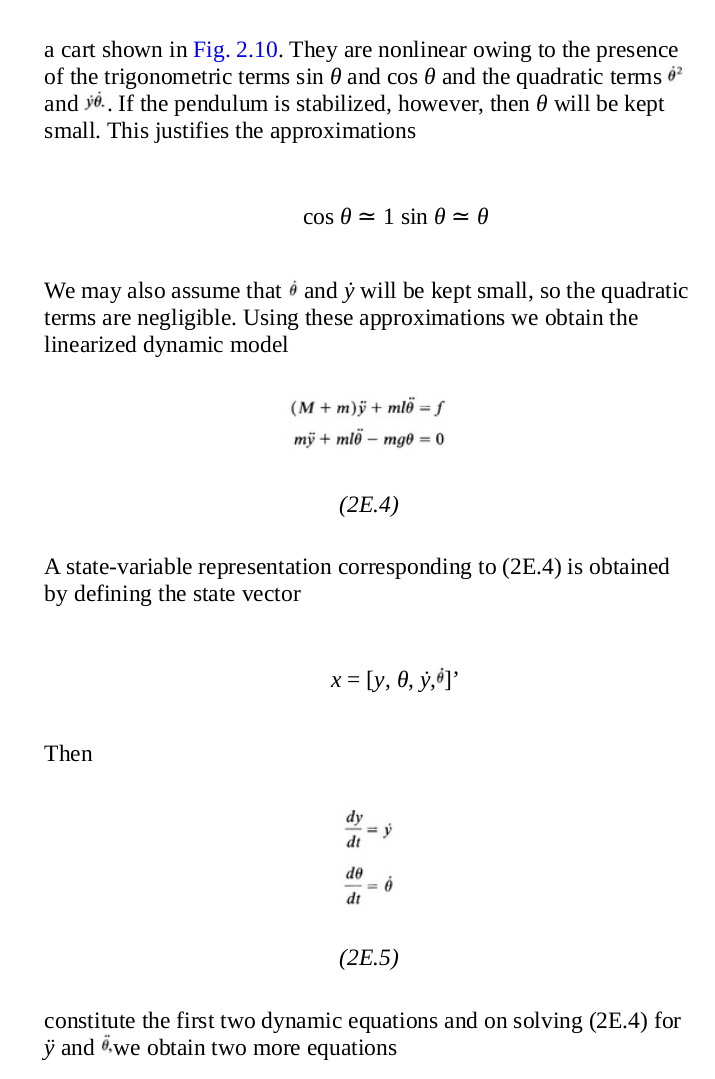

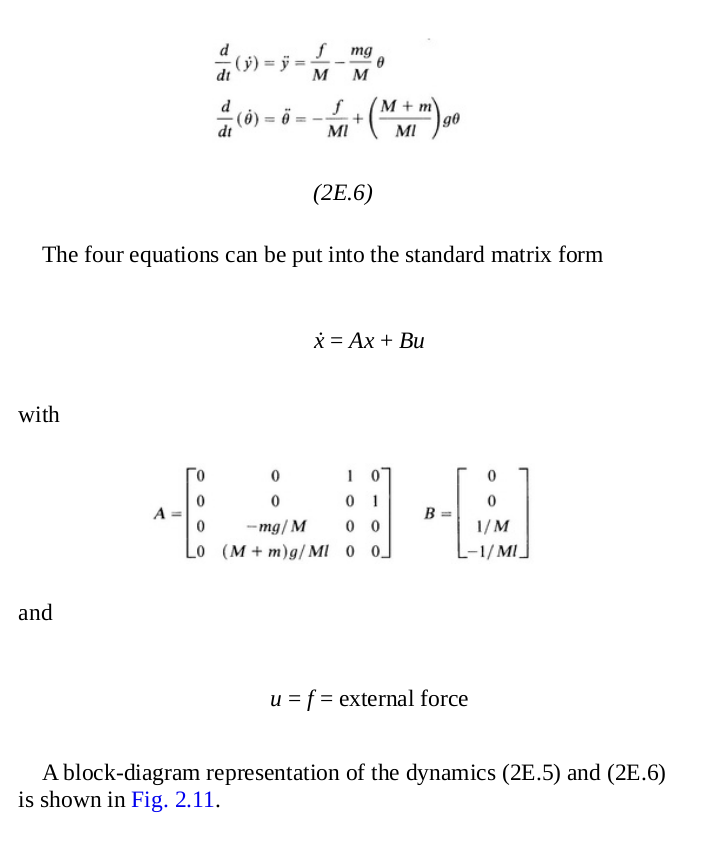

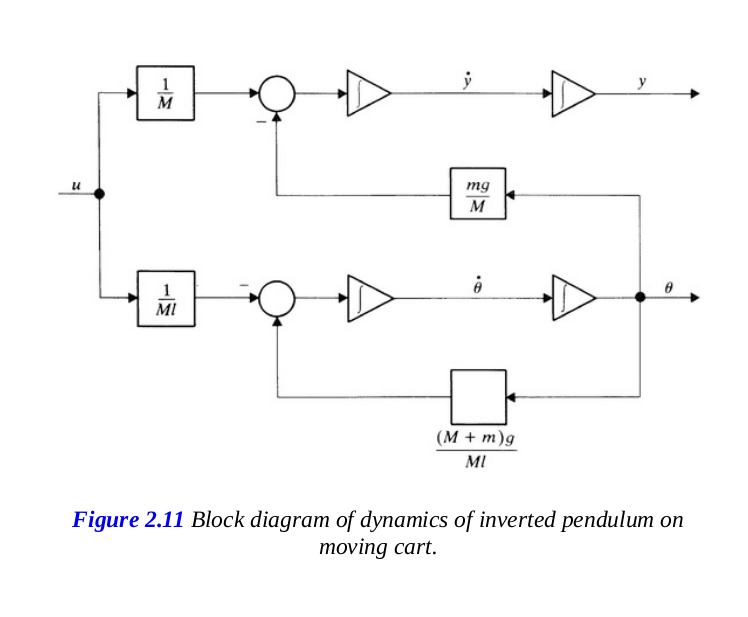

This is with the pendulum driven by a force.  In problem 2.2 which you did in Homework 2, we have the model when driven by an electric motor, which is what we have with our hardware. Here is the solution from Joe Dinius.

### Problem 2.1
The cart pendulum equations-of-motion are:

$$
\ddot y + \frac{mg}{M} \theta  =  \frac{f}{M} \\
\ddot \theta - \frac{M+m}{M \ell} g \theta  =  -\frac{f}{M \ell}
$$

$\tau = rf$, $r$ is the torque-to-linear-force factor.  For the electric motor:

$$
\tau  =  -\frac{k^2}{R} \omega + \frac{K}{R}e \\
 =  rf \\
\implies f  =  -\frac{k^2}{Rr} \omega + \frac{K}{Rr}e
$$

The linear acceleration, $\ddot y$, is equal to $\ddot y = r \dot \omega \implies \dot y = r \omega$ by Newton's law.  This implies:
$$
f  =  -\frac{k^2}{Rr^2} \dot y + \frac{K}{Rr}e
$$

Plug in $f$ to the first equation:
$$
\ddot y + \frac{mg}{M} \theta  =  -\frac{k^2}{MRr^2} \dot y + \frac{K}{MRr}e \\
\ddot \theta - \frac{M+m}{M \ell} g \theta  =  \frac{k^2}{MRr^2 \ell} \dot y - \frac{K}{MRr \ell}e
$$

Move state derivatives to the LHS:
$$
\ddot y +\frac{k^2}{MRr^2} \dot y + \frac{mg}{M} \theta  =  \frac{K}{MRr}e \\
\ddot \theta - \frac{k^2}{MRr^2 \ell} \dot y - \frac{M+m}{M \ell} g \theta   =  - \frac{K}{MRr \ell}e
$$

The next step is to take this linearized state model and put it into state form.  I am going to put the variable $s$ into the equations where $s=1$ for the pendulum up, and $s= -1$ for the pendulum down.

$$\begin{bmatrix} \dot y \\ \dot \theta \\ \ddot {y} \\ \ddot {\theta} \end{bmatrix}  = \begin{bmatrix} 0 && 0 && 1 && 0 \\ 0 && 0 && 0 && 1 \\ 0 && -mg/M && -k^2/(MRr^2)&& 0 \\ 0 && s(M+m)g/(Ml) && sk^2/(MRr^2l) && 0 \end{bmatrix} \begin{bmatrix}  y \\ \theta \\ \dot{y} \\  \dot {\theta} \end{bmatrix} + \begin{bmatrix} 0 \\ 0 \\ K/(MRr) \\ -sK/(MRrl) \end{bmatrix} e $$
so $$\mathbf A = \begin{bmatrix} 0 && 0 && 1 && 0 \\ 0 && 0 && 0 && 1 \\ 0 && -mg/M && -k^2/(MRr^2)&& 0 \\ 0 && s(M+m)g/(Ml) && sk^2/(MRr^2l) && 0 \end{bmatrix}$$ and $$\mathbf B = \begin{bmatrix} 0 \\ 0 \\ K/(MRr) \\ -sK/(MRrl) \end{bmatrix}$$

For an ideal motor, the torque constant is equal to the back electromotive force constant, so $k = K$. The applied voltage is $e$.  The mass of the cart is $M$; the resistance of the motor is $R$; the radius of the wheels (or pulley in our case) is $r$; and the mass of the pendulum is $m$, with $g$ for gravity.  For our pendulum, we might need to re-write these in terms of their moments of inertia sometime.  

For now let's assume all the states are available, so $$ \mathbf C = \begin{bmatrix} 1 && 0 && 0 && 0 \\ 0 &&  1 && 0 && 0 \\ 0 && 0 && 1 && 0 \\ 0 && 0 && 0 && 1 \end{bmatrix}$$

Let's see if our equations are good by simulating the system to see if it works like we expect. 
#### Unstable Pendulum (Standing up)
Let's begin with an investigation when the pendulum is standing up, not hanging down.  The model allows this with $s=1$.

In [ ]:
import control as ct

np.set_printoptions(precision=4)

def setupModel(M=0.3163,m=0.0318,R=4.09,r=0.0254/2,k=0.0351,K=k,l=0.323,g=9.81,s=-1):
    # Now the state model
    A = np.array([[0,0,1,0],[0,0,0,1],[0,-m*g/M,-k**2/(M*R*r**2),0],[0,s*(m+M)*g/(M*l),s*k**2/(M*R*r**2*l),0]])
    B = np.transpose(np.array([[0,0,K/(M*R*r),-s*K/(M*R*r*l)]]))
    C = np.eye(4);
    D = 0;
    pendsys = ct.ss(A, B, C, D)
    return pendsys

pendsys = setupModel(M=0.3163,m=0.0318,R=4.09,r=0.0254/2,k=0.0351,K=k,l=0.323,g=9.81,s=1)
print(pendsys)
x0 = [0,0.1,0,0]
t = np.arange(0, 10, 0.01)
(t, y) = ct.initial_response(pendsys,t, x0)

def displayPendSimulation(t, y):
    fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
    ax.plot(t, y[0,:])
    ax.plot(t, y[1,:])
    ax.plot(t, y[2,:])
    ax.plot(t, y[3,:])
    ax.legend([r'$y$', r'$\theta$', r'$\dot y$', r'$\dot \theta$'])
    plt.grid()
    
def getABCD(pendsys):
    # %% Getting the model matrices as lists and then as arrays :
    ( A_list , B_list , C_list , D_list ) = ct.ssdata(pendsys)
    A = np.array ( A_list )
    B = np.array ( B_list )
    C = np.array ( C_list )
    D = np.array ( D_list )
    return A, B, C, D
    
def displayEigenStuff(A):
    (w, v) = np.linalg.eig(A)
    print('Eigenvalues of A:', w)
    print('Eigenvectors of A:')
    print(v)
    return v, w
    
A, B, C, D = getABCD(pendsys)
v, w = displayEigenStuff(A)
displayPendSimulation(t, y)

error: the import function is not yet implemented in Octave
error: called from
    import at line 63 column 3
error: 'np' undefined near line 1, column 1
error: 'def' undefined near line 1, column 1
error: 'np' undefined near line 1, column 9
error: 'np' undefined near line 1, column 9
error: 'np' undefined near line 1, column 9
error: 'ct' undefined near line 1, column 15
error: parse error:

  syntax error

>>>     return pendsys
                     ^
error: 'setupModel' undefined near line 1, column 11
error: 'pendsys' undefined near line 1, column 7
x0 =

        0   0.1000        0        0

error: 'np' undefined near line 1, column 5
error: parse error:

  syntax error

>>> (t, y) = ct.initial_response(pendsys,t, x0)
      ^
error: 'def' undefined near line 1, column 1
error: parse error:

  syntax error

>>>     fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
                                         ^
error: parse error:

  syntax error

>>>     ax.plot(t, y[0,:])
   

Steve Brunton has some interesting things to say about how controllable a system is on his video [here](https://youtu.be/ZNHx62HbKNA?list=PLMrJAkhIeNNR20Mz-VpzgfQs5zrYi085m).  I want to check the single pendulum to see how controllable it is.  Steve describes how you can tell what directions are more controllable by doing the singular value decomposition of $\mathbf Q$ because Grammian $\mathbf W_t \approx  \mathbf {Q Q}^T$.

In [ ]:
Q = np.hstack([B, np.matmul(A, B), np.matmul(A, np.matmul(A, B)),np.matmul(A, np.matmul(A, np.matmul(A, B)))])
print(Q)
Rank_Q = np.linalg.matrix_rank(Q)
print('Rank of Q is:', Rank_Q)
print('SVD of Q:')
(U,S,V) = np.linalg.svd(Q, full_matrices=True)
print('U :')
print(U)
print('S :', S)
print('V :')
print(V)

error: 'np' undefined near line 1, column 5
error: 'Q' undefined near line 1, column 7
error: 'np' undefined near line 1, column 10
error: 'Rank_Q' undefined near line 1, column 24
error: print: no figure to print
error: called from
    print at line 448 column 5
error: parse error:

  syntax error

>>> (U,S,V) = np.linalg.svd(Q, full_matrices=True)
      ^
error: print: no figure to print
error: called from
    print at line 448 column 5
error: 'U' undefined near line 1, column 7
error: 'S' undefined near line 1, column 14
error: print: no figure to print
error: called from
    print at line 448 column 5
error: 'V' undefined near line 1, column 7


The second eigenvector is the unstable one.  Note its direction.  Then look at the least controllable direction.  Note its direction. We don't want them in the same direction.  To find the angle between them, we find the dot or inner product between them.  They both appear to be unit vectors the way python calculates them.

In [ ]:
print('The inner product between the most uncontrollable direction and the unstable pole is:')
print(v[:,1])
print(U[:,3])
inner_prod_of_unstable_eigenvector_with_difficult_to_control_direction = np.matmul(np.transpose(v[:,2]),U[:,3])
print(inner_prod_of_unstable_eigenvector_with_difficult_to_control_direction)
print('Just checking that the vectors are normalized when computed by python.  Here is the length of one of them.')
print('The eigenvector\'s length squared is: ')
print(np.matmul(np.transpose(v[:,1]),v[:,1]))
print('The length of U[3] is: ')
print(np.matmul(np.transpose(U[:,3]),U[:,3]))

error: print: no figure to print
error: called from
    print at line 448 column 5
error: parse error:

  syntax error

>>> print(v[:,1])
           ^
error: parse error:

  syntax error

>>> print(U[:,3])
           ^
error: parse error:

  syntax error

>>> inner_prod_of_unstable_eigenvector_with_difficult_to_control_direction = np.matmul(np.transpose(v[:,2]),U[:,3])
                                                                                                     ^
error: 'inner_prod_of_unstable_eigenvector_with_difficult_to_control_direction' undefined near line 1, column 7
error: print: unknown device 
error: called from
    __print_parse_opts__ at line 416 column 5
    print at line 420 column 8
error: parse error:

  syntax error

>>> print('The eigenvector\'s length squared is: ')
                            ^
error: parse error:

  syntax error

>>> print(np.matmul(np.transpose(v[:,1]),v[:,1]))
                                  ^
error: print: no figure to print
error: calle

The inner product is small and the length of the vectors that were compared is unity, so that is good!  It means they are practically orthogonal.  Now let's check to see if we place the poles at the same pole locations we started with, the gain coefficients are all come out very close to zero.  This is just a check of our the place algorithm.

In [ ]:
print('If we leave the poles alone, the gain matrix for this state feedback is:')
gain_for_no_pole_movement = ct.place(A, B, w) # Should be 0, 0, 0, 0.
print(gain_for_no_pole_movement)

error: print: no figure to print
error: called from
    print at line 448 column 5
error: 'ct' undefined near line 1, column 29
error: 'gain_for_no_pole_movement' undefined near line 1, column 7


### Stable Pendulum Simulation (Hanging Down)

In [ ]:
s = -1; # Hanging down
pendsys = setupModel(M=0.3163,m=0.0318,R=4.09,r=0.0254/2,k=0.0351,K=k,l=0.323,g=9.81,s=-1);
print(pendsys)
x0 = [0,0.1,0,0]
(t, y) = ct.initial_response(pendsys,t, x0)
A, B, C, D = getABCD(pendsys)
v, w = displayEigenStuff(A)
displayPendSimulation(t, y)

error: 'setupModel' undefined near line 1, column 11
error: 'pendsys' undefined near line 1, column 7
x0 =

        0   0.1000        0        0

error: parse error:

  syntax error

>>> (t, y) = ct.initial_response(pendsys,t, x0)
      ^
error: 'A' undefined near line 1, column 1
error: 'v' undefined near line 1, column 1
error: 't' undefined near line 1, column 23


Remember this is the result of a simulation of a linear model.  The question to ask is, "Is this accurate?"  To check this out, remember the approximations we made were $cos \theta \approx 1$ and $sin\theta \approx \theta$.  For the largest angles we see this works out to be:

In [ ]:
error_cos = np.cos(0.1)-1
error_sin = np.sin(0.1)-0.1
print('Error in cosine: ', error_cos)
print('Error in sine: ', error_sin)

error: 'np' undefined near line 1, column 13
error: 'np' undefined near line 1, column 13
error: 'error_cos' undefined near line 1, column 28
error: 'error_sin' undefined near line 1, column 26


This isn't the only source of error in our simulation.  There are at least a couple others.  One is due to not knowing the actual parameters very precisely. An approximate error analysis can be had by looking at the elements in the $A$ matrix to see how they vary as a function of each error.  For example if a coefficient, $a_{ij}=f(m,M,r,R,k,K,l)$ then the error is approximately:
$$da_{ij} = \frac {\partial a_{ij}} {\partial m} dm+ \frac {\partial a_{ij}} {\partial M} dM+\frac {\partial a_{ij}} {\partial r} dr+\frac {\partial a_{ij}} {\partial R} dR+\frac {\partial a_{ij}} {\partial k} dk+\frac {\partial a_{ij}} {\partial K} dK+\frac {\partial a_{ij}} {\partial l} dl$$



The only reason it damps out is the resistance of the motor windings.  We modeled no friction.  The underdamped responses (from complex poles) are expected.  There could be a damping effect from friction as well.  To tell if we should add that to the model, the thing to do is to actually hang the pendulum down, and see if the decay time of the oscillating wave is consistent with what the linear model predicts.

Not changing the pole locations results in a zero gain matrix as expected.  

Let's see if we can change the behavior of the pendulum so it is like it was in honey, dieing out in 1, 2, 3, and 4 seconds.  We will place the poles at -1, -2, -3 and -4.  Then do the simulation.

In [ ]:
G = ct.place(A,B,[-1,-2,-3,-4])
pendsys_fb = ct.ss(np.subtract(A, np.matmul(B, G)), B, C, D);
print(pendsys_fb)
x0 = [0, 0.1, 0, 0]
t, y = ct.initial_response(pendsys_fb, t, x0)
A_fb, B_fb, C_fb, D_fb = getABCD(pendsys_fb)
v, w = displayEigenStuff(A_fb)
displayPendSimulation(t, y)

error: 'ct' undefined near line 1, column 5
error: 'ct' undefined near line 1, column 14
error: 'pendsys_fb' undefined near line 1, column 7
x0 =

        0   0.1000        0        0

error: 't' undefined near line 1, column 1
error: 'A_fb' undefined near line 1, column 1
error: 'v' undefined near line 1, column 1
error: 't' undefined near line 1, column 23


Note how the cart moves to keep the natural swinging behavior from happening.  The reason it looks a little oscillatory is because some eigenmodes damp out faster and some slower.  

Note that the maximum angle is still $0.1^o$, so our previous check of the angles still applies.

It looks like we were successful placing the poles where we wanted them. 

I would like to know how much difference friction is making for the pendulum.  The simulation above may seem like a good place to start, but it assumes the input voltage is zero (shorted), but in that configuration, the resistance of the motor windings, $R$, causes damping.  So it would be nice to have a model where the current through the motor is zero.  This configuration would have no damping due to $i^2R$ losses in the motor.

### Zero Current Input Model
In this case, the torque $\tau$ is zero, because there is no Lorentz force with zero current.  This is as if the force was set to zero in the original pendulum model before incorporating the motor.  In this case the state model is:  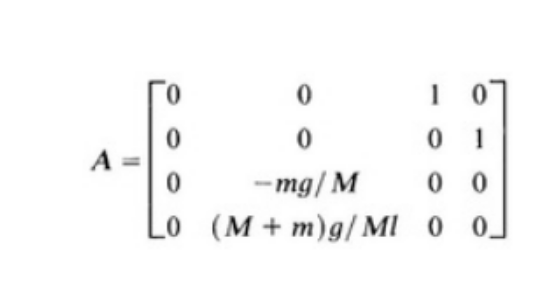

With the s variable included this becomes:

$$\begin{bmatrix} \dot y \\ \dot \theta \\ \ddot {y} \\ \ddot {\theta} \end{bmatrix}  = \begin{bmatrix} 0 && 0 && 1 && 0 \\ 0 && 0 && 0 && 1 \\ 0 && -mg/M && 0 && 0 \\ 0 && s(M+m)g/(Ml) && 0 && 0 \end{bmatrix} \begin{bmatrix}  y \\ \theta \\ \dot{y} \\  \dot {\theta} \end{bmatrix} + \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \end{bmatrix} u $$

This is like setting $k=K=0$ in the model.  Let's see if that does not decay, as we think it should.  It should also give us a better measurement of the viscous friction in the real system.  

In [ ]:
pendsys_nf  = setupModel(M=0.3163,m=0.0318,R=4.09,r=0.0254/2,k=0,K=0,l=0.323,g=9.81,s=-1)
print(pendsys_nf)
t, y = ct.initial_response(pendsys_nf, t, [0, 0.1, 0, 0])
A_nf, B_nf, C_nf, D_nf = getABCD(pendsys_nf)
v, w = displayEigenStuff(A_nf)
displayPendSimulation(t, y)

error: 'setupModel' undefined near line 1, column 15
error: 'pendsys_nf' undefined near line 1, column 7
error: 't' undefined near line 1, column 1
error: 'A_nf' undefined near line 1, column 1
error: 'v' undefined near line 1, column 1
error: 't' undefined near line 1, column 23


We should check the real pendulum and make sure the pendulum period is $T_p = (2\pi)/5.78144 = 1.0868$ seconds, assuming the damping is negligible.  If not, we should see what happens to this frequency as we add damping, and adjust our parameters so the period is correct based on what we think may be amiss.

### Model Verification and Adjustment
In this section we devise various ways to verify the model parameters and modify the model as seems best.  To do this we use the pendulum hanging down using the models for that developed above to verify/adjust and adjust the parameters for $\theta$, and then we put the pendulum on it's side and make a model to verify/adjust the motor parameters.

To do this we need to understand how the WWU pendulum works and how to operate it.  This the the WWU inverted pendulum.

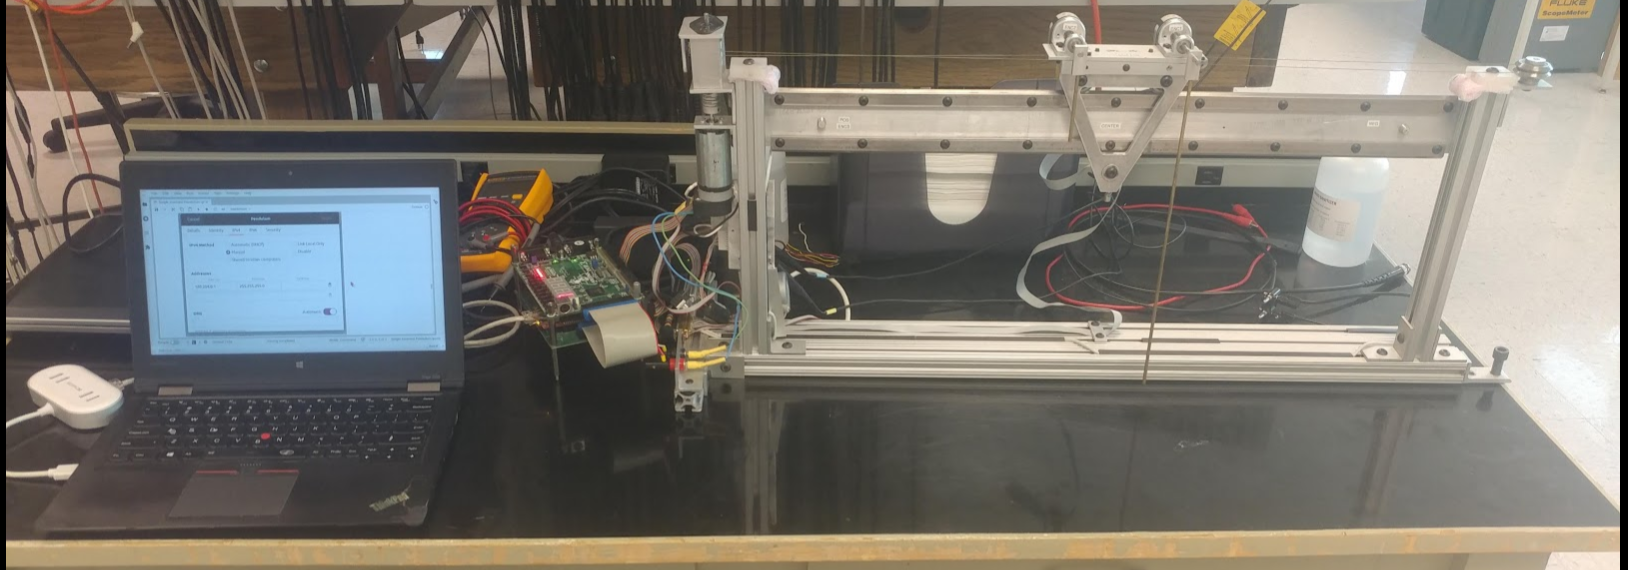

The pendulum motors and shaft angle encoders are controlled by a dedicated digital controller using a Xylinx FPGA that communicates with the user over Ethernet.  To control it you use Ralph's code from the ctrlbox.m file below.  You have to setup your computer to communicate with the pendulum at address 169.254.0.100.  Here are the settings for Ubuntu.

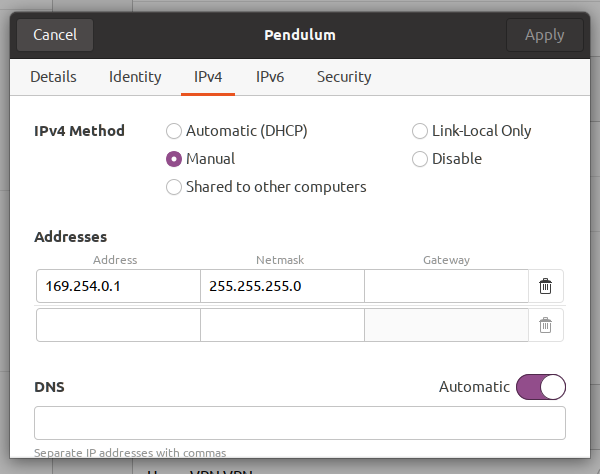 
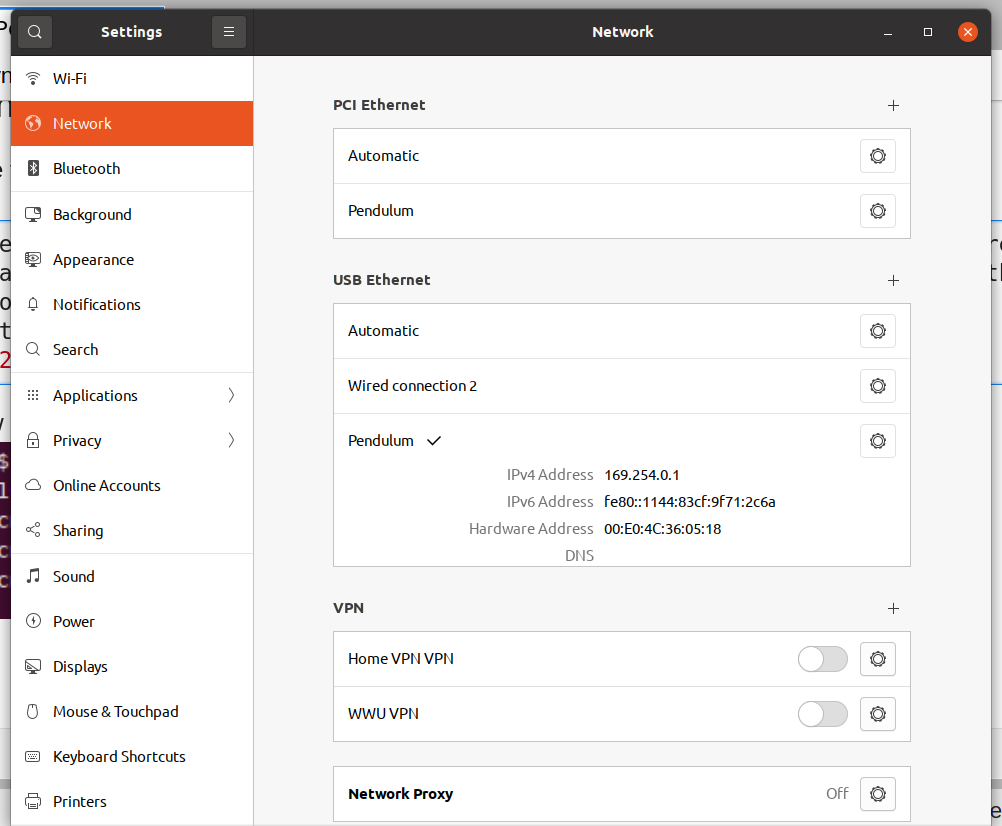

You can check it works as shown below (on linux).  If you can ping the pendulum, you can communicate with it.

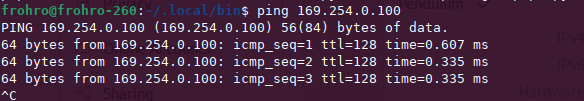

There are two physical pendula.  They have slightly different characteristics, and so the constants are different for each.  

The pendulum needs to know where down is, and where the center of the track is as well.  To set those you hit the reset button on the controller.  Sometimes you cannot ping the pendulum, and if you reset it, you can.  Here is a photo showing which button is the reset button.

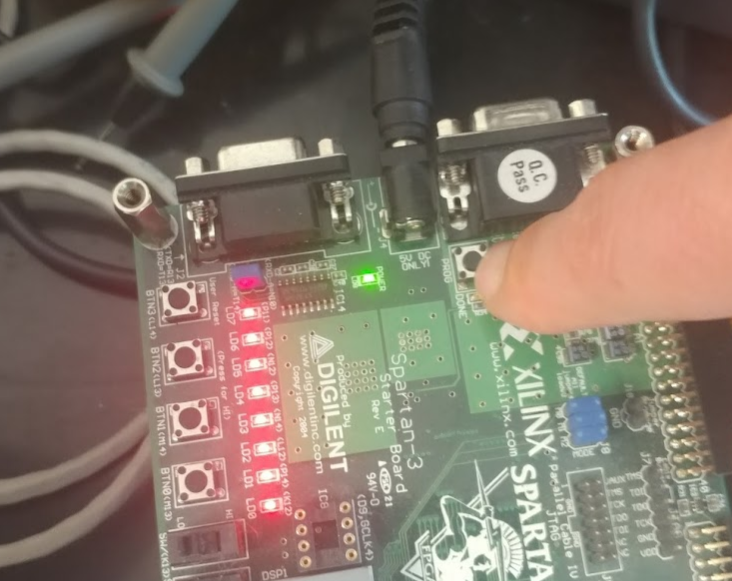


The ctrlbox.m file is shown below.  It contains the octave/MATLAB routines to communicate with the pendulum.  Ralph Stirling is the one who wrote them, and he is also the one who wrote the FPGA controller code to communicate with the Wiznet Ethernet device that the controller uses to send the data over Ethernet.  

In [ ]:
% ctrlbox.m
%
%    Functions for communication with the inverted pendulum
%    ctrlbox interface via ethernet.
%
% ctrlbox_init - initialize connection to ctrlbox
%
function rval = ctrlbox_init()
    global ctrlbox_con;

    ctrlbox_con = socket();
    sinfo = struct("addr","169.254.0.100", "port", 47820);
    rval = connect(ctrlbox_con,sinfo);

    return;
endfunction
%
% ctrlbox_send(cmdval,enable,period)
%  - send command value, enable, and sample period to ctrlbox
%    - cmdval = -32768 to +32767, where 32767=100% of DC bus voltage
%    - enable = 0 or 1
%    - period in usec
%
%  - future: measure time avg of pwm value, shutoff motor
%    if excessive.
function rval = ctrlbox_send(cmdval,enable,period)
    global ctrlbox_con;

    pwm = min(max(cmdval,-32000),32000);  % This keeps it in the interval (-32000, 32000).
    data = [pwm, 0, enable, period];
    send(ctrlbox_con, typecast(int32(data(1:4)),'uint8'));

    rval = 0;
    return;
endfunction
%
% ctrlbox_recv - receive an array of four values from ctrlbox
%
function data = ctrlbox_recv()
    global ctrlbox_con;

    [rdata,len] = recv(ctrlbox_con,16);

    if (len ~= 16)
        fprintf('short data: %d\n', len);  % Check to make sure we got it all.
    end

    data = double(typecast(rdata,'int32'));
    return;

endfunction

%
% ctrlbox_shutdown - shutdown connection to ctrlbox
%
function ctrlbox_shutdown()
    global ctrlbox_con;

    % turn off motor
    send(ctrlbox_con,typecast(int32([0,0,0,0]),'uint8'));

    disconnect(ctrlbox_con);
endfunction


Now we test the pendulum hanging down to see how it matches our model.

error: package sockets is not installed
error: called from
    load_packages at line 47 column 7
    pkg at line 632 column 7
error: 'setupModel' undefined near line 1, column 21
error: 'A' undefined near line 1, column 1
error: 'B' undefined near line 1, column 1
error: 'C' undefined near line 1, column 1
error: 'A' undefined near line 1, column 17
error: 'pendsys_fb' undefined near line 1, column 6
initial_angle_in_degrees = 5.7296
error: 'A' undefined near line 1, column 13
scale =

   1.5340e-03   1.5340e-03   1.9482e-05

'socket' undefined near line 4, column 19
error: 'send' undefined near line 5, column 5
error: called from
    ctrlbox_shutdown at line 5 column 5
error: invalid use of 'end': may only be used to index existing value
error: invalid use of 'end': may only be used to index existing value
error: 'theta' undefined near line 1, column 17
error: 'theta' undefined near line 1, column 8
error: 'thetadot' undefined near line 1, column 17




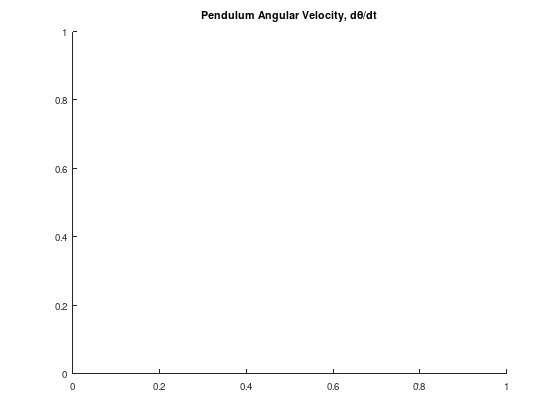

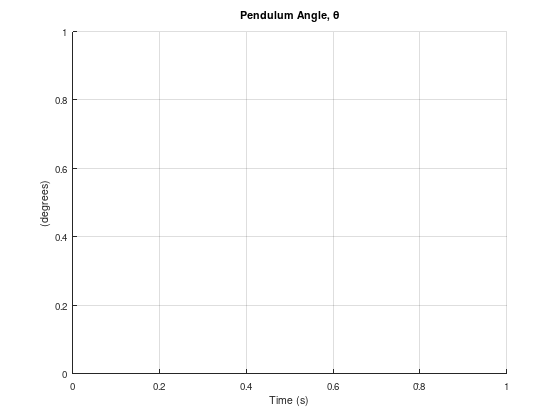

In [ ]:
% hanging_down.m
pkg load sockets control signal;
T=1/100;            % Sample time (1/sample_rate)
Trun= 10;           % Total time to run

% Simulate the system with the model we have
[pendsys,A,B,C,D] = setupModel(M=0.3163,m=0.0318,R=4.09,r=0.0254/2,k=0.0351/1.7,K=k,l=0.242,g=9.81,s=-1);
A
B
C
t = 0:T:Trun;
pendsys_fb = ss(A-B*g,zeros(4,1),eye(4),0);
lsim(pendsys_fb,zeros(size(t)),t,[0;0.1;0;0])  
initial_angle_in_degrees = 0.1*180/pi
[v,D] = eig(A)

% rdata(1) is the long angle (4096 counts per revolution) + is clockwise
% looking at the pendulum so the ribbon cable is on the left.
% rdata(2) is the short pendulum (4096 counts/rev) + clockwise
% rdata(3) is position with positive to the right
% rdata(4) is the CW_POS encoder near where the controlbox plugs in
rd = 0.0254/2;
scale = [2*pi/4096  2*pi/4096 2*pi*rd/4096]  % for receive data
cnt=Trun/T;            % number of times through loop
try
    ctrlbox_init();
    disp('finished ctrlbox_init');
    % send sample period
    period = 1000000.*T;  
    ctrlbox_send(0,0,period);
    ctrlbox_recv();  % The first data point is bad.  This ditches it.
    disp('finished send');
    tic;
        for c=1:cnt
        % read encoder values
        rdata = ctrlbox_recv();

        
        % force matlab to check for interrupts and flush event queue
        drawnow;
           
        % save data
        store(c,:) = [rdata];
    end
    runtime = toc;
    fprintf('transactions=%d seconds=%d transactions/sec=%f\n',
        c, runtime, c/runtime);
    drawnow;
catch
    % if something failed, display error and loop count
    disp(lasterror.message);
end

% disable motor and disconnect
ctrlbox_shutdown();

t=0:T:(cnt-1)*T; 
y = store(1:end,3)*scale(3);
theta = store(1:end,1)*scale(2);  
ydot = diff(y)/T;
thetadot = diff(theta)/T;

figure()
plot(t,theta*180/pi)
title('Pendulum Angle, \theta')
xlabel('Time (s)')
ylabel('(degrees)')
grid

figure()
plot(t(1:end-1),thetadot)
title('Pendulum Angular Velocity, d\theta/dt')
xlabel('Time (s)')
ylabel('(radians/s)')
grid

Here is a routine to test the pendulum.  This helps us understand how things work.  You need to install the octave-sockets package if you don't have it already.

The results from this simulation done with the motor open circuited, so the $R$ has no effect on the slow down of the pendulum seem to indicate that the major contribution to the pendulum friction is not viscous friction.  It seems to be a constant torque opposing motion, and it seems to drop off linearly with time instead of exponentially.  [This paper](http://phylab.fudan.edu.cn/lib/exe/fetch.php?media=home:xy-zhang:pend.pdf) analyzes this kind of motion.  Because it has the term $sgn(\dot \theta)$ in the torque because it changes sign when the angular velocity does, it would require changing models when $\dot \theta$ changes sign.  I don't want to mess with that at the moment.  I suspect the friction due to the cart moving on the rail is a bigger deal based on just feeling it with my fingers.  On that one, I'm not quite sure how to measure it, and I think it will likely also be a force with a $sgn(\dot y)$, I'm going to leave that out of my model too.  It may be possible to model those forces as proportional to $\dot \theta$ and $\dot y$, but they would give an exponential decay, and at least for the pendulum, it isn't exponential.  However, I do note from the paper that the frequency of oscillation is not a function of the friction, and I also note that the simulation and the measurement are a bit different in the frequency of oscillation.  I will take that into account by adjusting the length $l$ to the center of mass of the pendulum.  It appears that we measure five periods in about $4.7$ seconds, so the angular frequency is $2 \pi 5/4.7= 6.68$ radians per second.  Our simulation has nine periods in about $9.8$ seconds, so that gives an angular frequency of $2 \pi 9/9.8 = 5.7703$ which reminds me we can just get it from the eigenvalue, which was $5.78144$.  The characteristic polynomial of the $A$ matrix without the motor connected is $(Mls^4+Mgs^2+gms^2)/(Ml)$.  This makes it obvious there are two poles at zero, and the remainder of the poles satisfy $(Mls^2+Mg+gm)=0$ and so the poles are at $\pm j\sqrt{g(1+m/M)/l}$ and this agrees with what octave calculated above. I am not quite sure why, but it seems the of moment of inertia is not quite right, so I am going to reduce the length of the rod to get agreement.  The factor for which the resonant frequency is wrong is $6.68/5.78 = \sqrt{l_{old}/l_{new}} = \sqrt{0.323/l_{new}}$ so $l_{new}$ is calculated below as 0.242.  The analysis below verifies this change fixes things.

In [ ]:
l = .323/(6.68/5.78)^2
[pendsys_nf, A_nf]  = setupModel(M=0.3163,m=0.0318,R=4.09,r=0.0254/2,k=0,K=0,l,g=9.81,s=-1);
A_nf
[v,D] = eig(A_nf)
lsim(pendsys_nf, zeros(size(t)), t, [0; 0.1; 0; 0])

To start the pendulum, you need to let it hang down until it isn't moving.  Then you push the calibrate button on the FPGA board to tell it that is hanging down.  Then you set the initial condition and start your program.  The pause statement in octave lets you start it when you want with a single keystroke.
### Cart Falling Down
The force the motor develops is important.  We need to verify it, especially as some of the code from previous years seems to indicate that we might not have a good handle on the scale constant for the motor drive.  
If $J$ is the moment of inertia of the system:

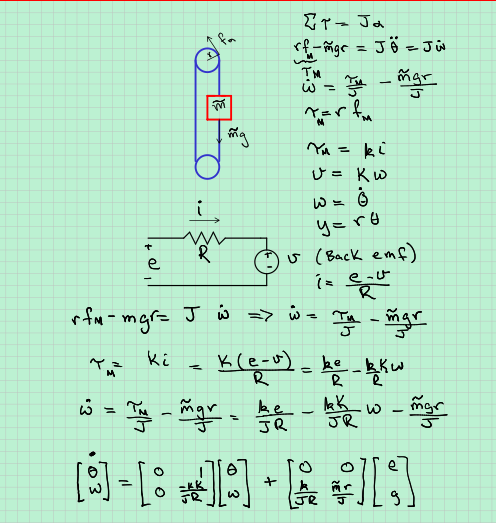

There is a minus sign missing in the $B$ matrix above.

The moment of inertia is made up of two parts, one from the motor and one from the mass so $J = J_M + \tilde{m}r^2$, and $\tilde m = m + M$, the total mass of the cart and pendulum.

A good test would be to see what motor voltage would hold the cart and pendulum up statically.  This is also useful, because we can do some dynamic tests around that operating point too if we like.  In this case, $\dot \omega = 0$, $\omega = 0$, and the back emf is also zero.  $ke = mgr$, and the voltage to hold the pendulum up should be $e = mgrR/(k) = (0.3163 + 0.0318)(9.81)(0.0254/2)/0.0351$.

In [ ]:
e_static = (0.3163 + 0.0318)*(9.81)*(0.0254/2)*4.09/(0.0351)

If there are no mistakes here, my experiments seem to indicate that the motor constant is $0.0351/1.7$.  (I need to send 1.7 times as much voltage as I calculate using the old motor constant.)  If I adjust the motor constant because of this, it becomes $0.0315/7.5$.  This is somewhat surprising and needs more verification somehow.

### State Feedback Hanging Down
Let's try to make the real pendulum die down with eigenmodes, $e^{-t}, e^{-2t}, e^{-3t},$ and $e^{-4t}$.  We have the state feedback for that computed above.  We will recalculate the $G$ gain, because we changed the effective length of the pendulum and the motor constant, $k$.

In [ ]:
% hanging_down_control.m
pkg load sockets control signal;
T=1/100
Trun= 10;

[pendsys,A,B,C,D] = setupModel(M=0.3163,m=0.0318,R=4.09,r=0.0254/2,k=0.0351/1.7,K=k,l=0.242,g=9.81,s=-1);
A
B
C
G = place(A,B,[-1,-2,-3,-4])
t = 0:T:Trun;
pendsys_fb = ss(A-B*G,zeros(4,1),eye(4),0);
lsim(pendsys_fb,zeros(size(t)),t,[0.1;0;0;0])
initial_angle_in_degrees = 0.1*180/pi
[v,D] = eig(A-B*G)

% rdata(1) is the long angle (4096 counts per revolution) + is clockwise
% looking at the pendulum so the ribbon cable is on the left.
% rdata(2) is the short pendulum (4096 counts/rev) + clockwise
% rdata(3) is position with positive to the right
% rdata(4) is the CW_POS encoder near where the controlbox plugs in

% Max checks not implemented yet
Maxpos = 0.25;              % Max carriage travel +- 0.25 m
Maxangle = 0.175;           % Max rod angle -- 10 deg
Maxvoltage = 20;            % Max motor voltage, V

rd = 0.0254/2;
scale = [2*pi/4096  2*pi/4096 2*pi*rd/4096]  % for receive data
cnt = Trun/T;            % number of times through loop

x1 = 0;
x2 = 0;  % initialize these
pwm_save = zeros(cnt,1);
try
    ctrlbox_init();
    disp('finished ctrlbox_init');
    % send sample period
    period = 1000000.*T; 
    ctrlbox_send(0,0,period);
    ctrlbox_recv();  % The first data point is bad.  This ditches it.
    disp('finished send');
    tic;
    for c=1:cnt
      x1m = x1;
      x2m = x2;
     % read encoder values
      rdata = ctrlbox_recv();
      x1 = rdata(3)*scale(3);
      x2 = rdata(1)*scale(1);
      x(:,c) = [x1; x2; (x1-x1m)/T; (x2-x2m)/T];  % calculate the state with derivative approximation.
      % pwm generation
      if c > 1  % Don't control until you have a derivative.
        pwm = ((-G*x(:,c))*32768)/20;  % the motor voltage appears to be 20V (check this)
        pwm_save(c) = pwm;
        % write pwm values and enable motor
        ctrlbox_send(pwm, 1, 0);
      end
    % force matlab to check for interrupts and flush event queue
    drawnow;
    % save data
    store(c,:) = [rdata];
    end
    runtime = toc;
    fprintf('transactions=%d seconds=%d transactions/sec=%f\n',
        c, runtime, c/runtime);
    drawnow;
catch
    % if something failed, display error and loop count
    disp(lasterror.message);
end

% disable motor and disconnect
ctrlbox_shutdown();

t=0:T:(cnt-1)*T; 
y = store(1:end,3)*scale(3);
theta = store(1:end,1)*scale(2); 
ydot = diff(y)/T;
thetadot = diff(theta)/T;

figure()
plot(t,y)
title('Pendulum Position, y')
xlabel('Time (s)')
ylabel('(m)')
grid

figure()
plot(t,theta*180/pi)
title('Pendulum Angle, \theta')
xlabel('Time (s)')
ylabel('(degrees)')
grid

figure()
plot(t(1:end-1),ydot)
title('Pendulum Velocity, dy/dt')
xlabel('Time (s)')
ylabel('(m/s)')
grid

figure()
plot(t(1:end-1),thetadot)
title('Pendulum Angular Velocity, d\theta/dt')
xlabel('Time (s)')
ylabel('(radians/s)')
grid

Playing with this seems to indicate that it is very insensitive to position in real life.  Note the places of zero velocity in the results.  This is non-linear behavior.  I believe it is due to friction. 

####  Friction Musings
I wonder if a good way to account for the friction is to make a model for travelling in each direction, and have a constant friction force in each direction that just changes sign with each direction change.  We could design the control for each direction, and then just change the value when the sign of the movement changes.  A thing that worries me is that the Q point is exactly where we would change the model.  I suppose we could control at that point as if there was no friction at all, but actually the static friction is probably even greater than the friction for motion, and when it is static, I cannot use the direction of motion to determine its direction.  I do know the force of the motor in the static case, so it might be possible to model the friction using Coulomb's friction relation, $F = \mu N$.  The cart friction seems greater than the pendulum friction, so that is my principle concern, but the two seems very similar in the way they work, so solving one will probably solve the other.  If we add this frictional force for the cart, it will be:

$$
f_{F} =  \begin{cases} 
      \mu_d(M+m) & \dot y > 0 \\
      - \mu_s(m+M) sgn(f_M) & \dot y = 0 \\
      -\mu_d(M+m) & \dot y < 0 
\end{cases}
$$

where $f_F$ is the force of friction, $f_M$ is the force of the motor, $M$ is the mass of the cart, $m$ is the mass of the pendulum, $\mu_s$ is the static friction, and $\mu_d$ is the dynamic friction, $\dot y$ is the velocity of the cart and $f_M$ is the force of the motor. The appropriate equations we need to add the force of friction into are:
$$
$$
\ddot y + \frac{mg}{M} \theta  =  \frac{f}{M} \\
\ddot \theta - \frac{M+m}{M \ell} g \theta  =  -\frac{f}{M \ell}
$$
$$
The force $f$ now (including friction) needs to be the force due to the motor plus the frictional force.  $$ f \rightarrow f_M + f_F$$
$\tau = rf$, $r$ is the torque-to-linear-force factor, the radius of the pulley.  For the electric motor:
$$
$$
\tau_M  =  -\frac{k^2}{R} \omega + \frac{K}{R}e \\
 =  rf_M \\
\implies f_M  =  -\frac{k^2}{Rr} \omega + \frac{K}{Rr}e
$$
$$
The linear acceleration, $\ddot y$, is equal to $\ddot y = r \dot \omega \implies \dot y = r \omega$ by Newton's law.  This implies:
$$
$$
f_M  =  -\frac{k^2}{Rr^2} \dot y + \frac{K}{Rr}e
$$
$$

Plug in $f$ to the first equation:
$$
$$
\ddot y + \frac{mg}{M} \theta  =  -\frac{k^2}{MRr^2} \dot y + \frac{K}{MRr}e + \frac{f_F}{M}\\
\ddot \theta - \frac{M+m}{M \ell} g \theta  =  \frac{k^2}{MRr^2 \ell} \dot y - \frac{K}{MRr \ell}e -\frac{f_F}{M\ell}
$$
$$
Move state derivatives to the LHS:
$$
$$
\ddot y +\frac{k^2}{MRr^2} \dot y + \frac{mg}{M} \theta  =  \frac{K}{MRr}e + \frac{f_F}{M}\\
\ddot \theta - \frac{k^2}{MRr^2 \ell} \dot y - \frac{M+m}{M \ell} g \theta   =  - \frac{K}{MRr \ell}e -\frac{f_F}{M\ell}
$$
$$
Now we need to go about measuring the friction coefficients, $\mu_d$, and $\mu_s$.  Then we need to code the frictional force into a piecewise model.  To measure $\mu_s$ we could just start the cart an a stationary position, and increase the motor force until it barely moves.  To measure $\mu_d$ we will tilt the pendulum up until the cart slides down the incline, and measure the position as a function of time.  This should give us a pretty good idea of the dynamic frictional force.

The plan for measuring the Coulomb friction coeficients, $\mu_s$ and $\mu_d$ is to set the cart on an angle and measure $y$.  The static friction can be determined from the maximum angle before which the cart moves and the dynamic friction from the acceleration when the cart does move.  See the diagram below.

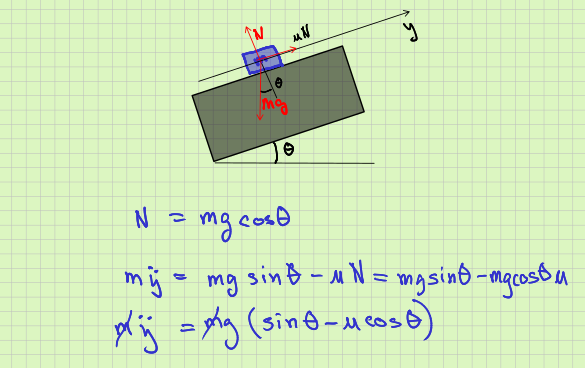

We will gradually raise the pendulum up until the cart rolls.  We will record the angle that it rolls.  The script below will record $y$ and $\dot y$.

In [ ]:
% measure_friction.m
pkg load sockets control signal;
T=1/100;            % Sample time (1/sample_rate)
Trun= 10;           % Total time to run

% rdata(1) is the long angle (4096 counts per revolution) + is clockwise
% looking at the pendulum so the ribbon cable is on the left.
% rdata(2) is the short pendulum (4096 counts/rev) + clockwise
% rdata(3) is position with positive to the right
% rdata(4) is the CW_POS encoder near where the controlbox plugs in
rd = 0.0254/2;
scale = [2*pi/4096  2*pi/4096 2*pi*rd/4096];  % for receive data
cnt=Trun/T;            % number of times through loop
try
    ctrlbox_init();
    disp('finished ctrlbox_init');
    % send sample period
    period = 1000000.*T;  
    ctrlbox_send(0,0,period);
    ctrlbox_recv();  % The first data point is bad.  This ditches it.
    disp('finished send');
    tic;
    for c=1:cnt
        % read encoder values
        rdata = ctrlbox_recv();

        
        % force matlab to check for interrupts and flush event queue
        drawnow;
           
        % save data
        store(c,:) = [rdata];
    end
    runtime = toc;
    fprintf('transactions=%d seconds=%d transactions/sec=%f\n',
        c, runtime, c/runtime);
    drawnow;
catch
    % if something failed, display error and loop count
    disp(lasterror.message);
end

% disable motor and disconnect
ctrlbox_shutdown();

t=0:T:(cnt-1)*T; 
y = store(1:end,3)*scale(3); 
theta = store(1:end,1)*scale(2); 
ydot = diff(y)/T;
thetadot = diff(theta)/T;

figure()
plot(t,y)
title('Pendulum Position, y')
xlabel('Time (s)')
ylabel('(meters)')
grid

figure()
plot(t(1:end-1),ydot)
title('Pendulum Velocity, dy/dt')
xlabel('Time (s)')
ylabel('(m/s)')
grid

The height to get it going is 15 cm.  The horizontal dimension of the carriage is 34 cm, so $sin(\theta) = 15/34$.  You need to make this test with no motor connected so it doesn't slow the cart down.  The angle is calculated below.  I thinkI should hold the carriage at a higher angle to measure $\mu_d$.  The friction is a  function of the position of the carriage, $y$.  Doing this will help overcome that problem.

In [ ]:
friction_angle = asin(15/34)
mu_s = tan(friction_angle)
friction_angle_degrees = friction_angle*180/pi

Experiments show that the cart will not move when the rail is horizontal until the pwm number to the cart is between 3000 and 3500.  This indicates the static friction motor voltage is about:

In [ ]:
Static_friction_motor_voltage = 3300/32768*20

This piecewise linear approach seems to have been used by people all the way back to Kalman.  The [theory](https://portal.research.lu.se/portal/files/4673551/8571461.pdf) is beyond the scope of this class, but trying it out isn't.  

Let's try to simulate it using octave's ode45 function.  First we need a force function.

In [ ]:
% friction.m
function force = friction(mu_s, mu_d, ydot, mass, u)
    if (ydot < 0)
      force = mu_d*mass;
    elseif (ydot == 0)
      force = -mu_s*mass*sign(u);
    else
      force = -mu_d*mass;
    endif
endfunction

Now let's make a right hand side.  Then let's simulate it.

In [ ]:
% simulate_friction.m
function dxdt = rhs(t, x)
    M=0.3163;m=0.0318;R=4.09;r=0.0254/2;k=0.0351/1.7;K=k;l=0.242;g=9.81;s=-1;
    A = [[0,0,1,0];[0,0,0,1];[0,-m*g/M,-k^2/(M*R*r^2),0];[0,s*(m+M)*g/(M*l),s*k^2/(M*R*r^2*l),0]];
    B = [0;0;K/(M*R*r);-s*K/(M*R*r*l)];
    G = place(A,B,[-1,-2,-3,-4]);
    dxdt = (A-B*G)*x +[0;0;1/M; 1/M/l]*friction(0.42,0.3, x(3),M+m,-G*x);
endfunction
function sim_friction
    Trun = 10;
    T = 1/100;
    t = 0:T:Trun;
    [t, x] = ode45(@rhs, t, [0; 0.1; 0; 0]);
    plot(t, x)
    legend('y','\theta','dy/dt','d\theta /dt')
    title('Controlled Pendulum With Friction')
endfunction
sim_friction
grid

This looks like what we observe.  I need to compare the frequency of oscillations the experimental results.  Note the flat places in the cart velocity, $\dot y$.

### Full Order Observer (Hanging Down)
The full order observer is a system that monitors the actual system, taking as inputs the input of the actual system and the output of the system, and it's state, $\hat x$ is made to simulate the system so that the error, $e = (x-\hat x)$ tends to zero as with the eigenvalues we wish it to have.  That means that $\hat e=\tilde A e$.  Here is a quick derivation of how it works.  The whole purpose of it is that sometimes we don't have access to all the states because they are not measured, or they are measured only with a lot of noise, and we want a better thing.  We then use the estimates $\hat x$ instead of $x$ for the control. 

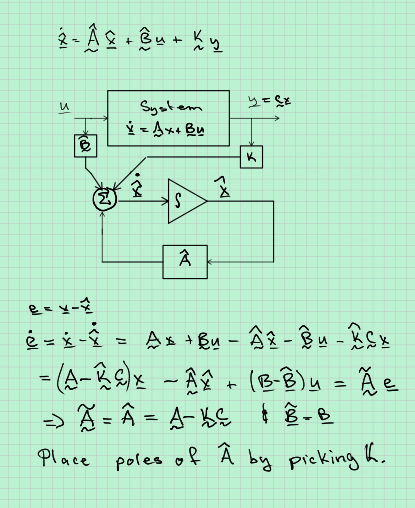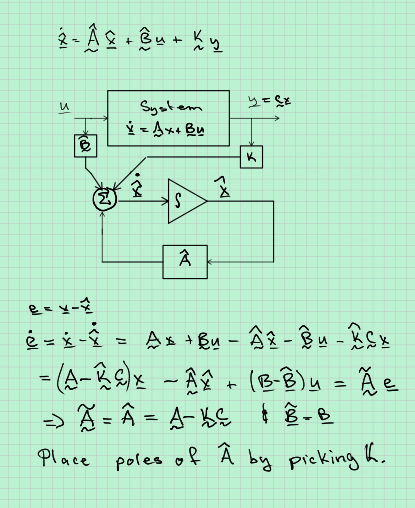

To build a full order observer, we begin by deciding where we want the poles of the observer to be placed, and then use the place routine in octave to find the $K$ gain matrix that will do that.  Then you just build the simulator system into the control program.

For my test, I want to compare the simulated and measured states.  The pendulum actually measures the angle, $\theta$ and the position $y$.  Note the unfortunate circumstance that the canonical variables $y$ and $e$ now have two interpretations each.  I'm sorry about that.  I'm trying to use the variables most often used in the textbook and literature.  First we need to check the observability matrix and see if our pendulum system is observable.

In [ ]:
C = [1,0,0,0; 0,1,0,0]
R = [C',A'*C',A'^2*C',A'^3*C']
rank_R = rank(R)

So it is observable.  Now let's find the gain matrix, $K$.  Note this is like placing the poles for the controller if we use the transpose, because the eigenvalues are not changed by taking the transpose of the matrix, and $(KC)^T = C^T K^T$.  We want the equation to match the one we used to place the poles of the controller and it does by doing the transpose, so we just place the poles of the transpose.  

In [ ]:
desired_observer_poles = [-40, -41, -42, -43]
K = place(A', C',desired_observer_poles)

Let's investigate how this should work in theory with a simulation.

In [ ]:
Trun = 10;
T=1/100
[pendsys,A,B,Cid,D] = setupModel(M=0.3163,m=0.0318,R=4.09,r=0.0254/2,k=0.0351/1.7,K=k,l=0.242,g=9.81,s=-1);
A
B
R = [C',A'*C',A'^2*C',A'^3*C']
rank_R = rank(R)
desired_observer_poles = [-40, -41, -42, -43]
C = [1,0,0,0; 0,1,0,0]
K = place(A', C',desired_observer_poles)'
G = place(A,B,[-1,-2,-3,-4])
t = 0:T:Trun;
pendsys_fb = ss(A-B*G,zeros(4,1),eye(4),0);
y = lsim(pendsys_fb,zeros(size(t)),t,[0;0.1;0;0]);
initial_angle_in_degrees = 0.1*180/pi
[v,D] = eig(A-B*G)

Ahat = A-K*C
Bhat = B
Chat = eye(4);
obs_poles = eig(A-K*C)
obs_sys = ss(A-B*G-K*C, Bhat, Chat)
xhat = lsim(obs_sys, zeros(size(t)), t, [0;0.1;0;0]);
err = y - xhat;
plot(t, err)
title('Error')
xlabel('Time (s)')

Note this simulation is not feeding the simulated values back using state feedback yet.  We want to see how the observer converges before we take that step, so the simulation above is appropriate. 

This did not include friction.  It would be interesting to include friction in the simulation of the observer to see what happens to the observer outputs.  Based on the real world results below, it would not work very well.  This means we want to think about how we might include friction in the observer itself.

Now let's modify the control code so we can try what we did above on the real system (without friction).  To do this, to start with, I am going to use a simple Euler approximation for $\dot {\hat x}(kT) \approx [\hat x((k+1)T)-\hat x(kT)]/T $.  With this,
$$ \dot {\hat x} = \hat {A} \hat x + \hat B u + KC x $$  becomes  
$$ \hat {x}((k+1)T) \equiv \hat x (k+1) \approx (I+ \hat {A} T)\hat {x}(k) + B u(k) + KCx(k)$$

In [ ]:
setupModel(M=0.3163,m=0.0318,R=4.09,r=0.0254/2,k=0.0351/1.7,K=k,l=0.242,g=9.81,s=-1);

In [ ]:
% hanging_down_control_full_order_observer.m
%clear all;
%close all;
%pkg load sockets control signal;
%ctrlbox;
T=1/100
Trun= 10;


[pendsys,A,B,C,D] = setupModel(M=0.3163,m=0.0318,R=4.09,r=0.0254/2,k=0.0351/1.7,K=k,l=0.242,g=9.81,s=-1);
A
B
C = [1,0,0,0; 0,1,0,0]
R = [C',A'*C',A'^2*C',A'^3*C']
rank_R = rank(R)
desired_observer_poles = [-40, -41, -42, -43]
K = place(A', C',desired_observer_poles)'
G = place(A,B,[-1,-2,-3,-4])
t = 0:T:Trun;
pendsys_fb = ss(A-B*G,zeros(4,1),eye(4),0);
lsim(pendsys_fb,zeros(size(t)),t,[0;0.1;0;0])
initial_angle_in_degrees = 0.1*180/pi
[v,D] = eig(A-B*G)

Ahat = A-K*C
% rdata(1) is the long angle (4096 counts per revolution) + is clockwise
% looking at the pendulum so the ribbon cable is on the left.
% rdata(2) is the short pendulum (4096 counts/rev) + clockwise
% rdata(3) is position with positive to the right
% rdata(4) is the CW_POS encoder near where the controlbox plugs in

% Max checks not implemented yet
Maxpos = 0.25;              % Max carriage travel +- 0.25 m
Maxangle = 0.175;           % Max rod angle -- 10 deg
Maxvoltage = 20;            % Max motor voltage, V

rd = 0.0254/2;
scale = [2*pi/4096  2*pi/4096 2*pi*rd/4096]  % for receive data
cnt = Trun/T;            % number of times through loop

x1 = 0;
x2 = 0;  % initialize these
pwm_save = zeros(cnt,1);
xhat = zeros(4,1);
try
    ctrlbox_init();
    disp('finished ctrlbox_init');
    % send sample period
    period = 1000000.*T; 
    ctrlbox_send(0,0,period);
    ctrlbox_recv();  % The first data point is bad.  This ditches it.
    disp('finished send');
    tic;
    for c=1:cnt
      x1m = x1;
      x2m = x2;
     % read encoder values
      rdata = ctrlbox_recv();
      x1 = rdata(3)*scale(3);
      x2 = rdata(1)*scale(1);
      Cx = C*[x1; x2; 0; 0];
      
      x(:,c) = [x1; x2; (x1-x1m)/T; (x2-x2m)/T];  % calculate the state with derivative approximation.
      % pwm generation
      if c > 1  % Don't control until you have a derivative.
        pwm = ((-G*x(:,c))*32768)/20;  % the motor voltage appears to be 20V (check this)
        pwm_save(c) = pwm;
        % write pwm values and enable motor
        ctrlbox_send(pwm, 1, 0);
      endif
      % force matlab to check for interrupts and flush event queue
      drawnow;
      xhat = (eye(4)+Ahat*T)*xhat + B*(-G*x(:,c)) +K*Cx;
    % save data
      hatx(c,:) = xhat;
      store(c,:) = [rdata];
    endfor
    runtime = toc;
    fprintf('transactions=%d seconds=%d transactions/sec=%f\n',
        c, runtime, c/runtime);
    drawnow;
catch
    % if something failed, display error and loop count
    disp(lasterror.message);
end

% disable motor and disconnect
ctrlbox_shutdown();

t=0:T:(cnt-1)*T;  
y = store(1:end,3)*scale(3);
theta = store(1:end,1)*scale(2);  
ydot = diff(y)/T;
thetadot = diff(theta)/T;

size_t = size(t)
theta_size = size(theta)
dot_theta_size = size(thetadot)
figure()
plot(t,y)
title('Pendulum Position, y')
xlabel('Time (s)')
ylabel('(m)')
grid

figure()
plot(t,theta*180/pi)
title('Pendulum Angle, \theta')
xlabel('Time (s)')
ylabel('(degrees)')
grid

figure()
plot(t(1:end-1),ydot)
title('Pendulum Velocity, dy/dt')
xlabel('Time (s)')
ylabel('(m/s)')
grid

figure()
plot(t(1:end-1),thetadot)
title('Pendulum Angular Velocity, d\theta/dt')
xlabel('Time (s)')
ylabel('(radians/s)')
grid

figure()
plot(t,y,t,hatx(:,1),t,y-hatx(:,1))
title('Observer')
legend('y','hatx(1)','e')
xlabel('Time (s)')

#### Adding Friction to the State Feedback in the Real Pendulum Hardware
The $A$ matrix is not changed by the friction.  The $B$ matrix is not able to simulate the constant frictional forces that depend only on the signs of $\dot y$ and $f_M$.  This means the way to compensate for friction is to add in an equal and opposite force using the motor.

Recall $\tau = rf_M$, $r$ is the torque-to-linear-force factor (radius of the pulley).  For the electric motor:
$$\tau = k i$$
$$ i = \frac{e-v}{R}$$
$$ v = k\omega$$
so putting that all together
$$ \tau  = \frac{-k^2\omega}{R} + \frac{ke}{R}$$ or
$$ f_M = \frac{\tau}{ r} = \frac{-k^2\omega}{rR} + \frac{ke}{Rr}$$
We want to add a "constant" anti-friction force to the motor force by changing $e$, or equivalently add an anti-friction torque, $\tau$.  The value of the force is $$f_{AF} = -f_F = \frac{ke_{AF}}{Rr}$$  so the extra vlotage we need to add is $$e_{AF} = \frac{-rRf_F}{k}$$

In [ ]:
% hanging_down_friction_control.m
pkg load sockets control signal;
T=1/100
Trun= 10;

R=4.09; k=0.0351/1.7; M=0.3163; m=0.0318; mass = m + M; R=4.09; r=0.0254/2; k=0.0351/1.7;K=k;l=0.242,g=9.81;s=-1;
G = place(A,B,[-1,-2,-3,-4]);
t = 0:T:Trun;
pendsys_fb = ss(A-B*G,zeros(4,1),eye(4),0);
lsim(pendsys_fb,zeros(size(t)),t,[0.1;0;0;0])
initial_angle_in_degrees = 0.1*180/pi
[v,D] = eig(A-B*G)

% rdata(1) is the long angle (4096 counts per revolution) + is clockwise
% looking at the pendulum so the ribbon cable is on the left.
% rdata(2) is the short pendulum (4096 counts/rev) + clockwise
% rdata(3) is position with positive to the right
% rdata(4) is the CW_POS encoder near where the controlbox plugs in

% Max checks not implemented yet
Maxpos = 0.25;              % Max carriage travel +- 0.25 m
Maxangle = 0.175;           % Max rod angle -- 10 deg
Maxvoltage = 20;            % Max motor voltage, V

rd = 0.0254/2;
scale = [2*pi/4096  2*pi/4096 2*pi*rd/4096]  % for receive data
cnt = Trun/T;            % number of times through loop

e_m = 0;
x1 = 0;
x2 = 0;  % initialize these
pwm_save = zeros(cnt,1);
try
    ctrlbox_init();
    disp('finished ctrlbox_init');
    % send sample period
    period = 1000000.*T; 
    ctrlbox_send(0,0,period);
    ctrlbox_recv();  % The first data point is bad.  This ditches it.
    disp('finished send');
    tic;
    for c=1:cnt
      x1m = x1;
      x2m = x2;
     % read encoder values
      rdata = ctrlbox_recv();
      x1 = rdata(3)*scale(3);
      x2 = rdata(1)*scale(1);
      x3 = (x1-x1m)/T;
      x4 = (x2-x2m)/T;
      x(:,c) = [x1; x2; x3; ];  % calculate the state with derivative approximation.
      % pwm generation
      if c > 1  % Don't control until you have a derivative.
        u = e_m;
        e_m = (-G*x(:,c))-friction(mu_s, mu_d, x3, mass, u)*r*R/k;
        pwm = (e_m*32768)/20;  % the motor voltage appears to be 20V (check this)
        pwm_save(c) = pwm;
        % write pwm values and enable motor
        ctrlbox_send(pwm, 1, 0);
      end
    % force matlab to check for interrupts and flush event queue
    drawnow;
    % save data
    store(c,:) = [rdata];
    end
    runtime = toc;
    fprintf('transactions=%d seconds=%d transactions/sec=%f\n',
        c, runtime, c/runtime);
    drawnow;
catch
    % if something failed, display error and loop count
    disp(lasterror.message);
end

% disable motor and disconnect
ctrlbox_shutdown();

t=0:T:(cnt-1)*T; 
y = store(1:end,3)*scale(3);
theta = store(1:end,1)*scale(2); 
ydot = diff(y)/T;
thetadot = diff(theta)/T;
figure()
plot(t,y)
title('Pendulum Position, y')
xlabel('Time (s)')
ylabel('(m)')
grid

figure()
plot(t,theta*180/pi)
title('Pendulum Angle, \theta')
xlabel('Time (s)')
ylabel('(degrees)')
grid

figure()
plot(t(1:end-1),ydot)
title('Pendulum Velocity, dy/dt')
xlabel('Time (s)')
ylabel('(m/s)')
grid

figure()
plot(t(1:end-1),thetadot)
title('Pendulum Angular Velocity, d\theta/dt')
xlabel('Time (s)')
ylabel('(radians/s)')
grid

## State Feedback With the Unstable Pendulum
Let's now go back to the unstable pendulum and try to place the poles where we want them.  We will need to use a numerical approximation for the derivative to get the state variables for $\dot y$ and $\dot \theta$ for the actual pendulum, but first, let's simulate state feedback.

It might be good to use the LQR regulator to choose the poles to start with.  A good article on that is [this one
](https://lewisgroup.uta.edu/Lectures/lqr.pdf) from the University of Texas at Arlington.  It explains how to pick the $Q$ and $R$ matrices.  The $Q$ matrix tells how much energy you want the states to have (how quickly you want them to approach zero) and the $R$ matrix tells you how much energy you want to expend to get them there.  The relative sizes of each of these elements is the key.

### Homework 12 Help

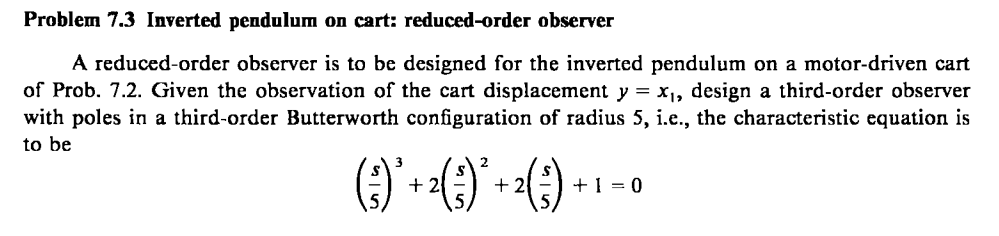

We will do this problem for the WWU pendulum.  First we need to see if the system is observable with just one state, and if so, what state will work.  For $\theta$ as the measured variable, we have $C=\begin {bmatrix} 0 && 1 && 0&&0 \end {bmatrix}$.  We need to compute the rank of the observability matrix, $R$, with this $C$.

In [ ]:
[pendsys,A,B,C,D] = setupModel();
A
C = [0 1 0 0]
R = [C', A'*C', A'^2*C', A'^3*C']
rank_R = rank(R)

That is not observable.  Looks like we can't measure $y$.  If we measure $y$ instead, is it observable?  

In [ ]:
C = [1 0 0 0]
R = [C', A'*C', A'^2*C', A'^3*C'];
rank_R = rank(R)

That is observable!  So we don't have to swap the order of the state variables!  Nice!

Let's find where the poles need to be placed for the observer by finding $L$.

In [ ]:
poles_F = roots([(1/5)^3 2*(1/5)^2 2/5 1])
A22 = A(2:end, 2:end)
A12 = A(1,2:end)
C1 = 1
LTranspose = place(A22', A12'*C1', poles_F)
eigs(A22 -LTranspose'*C1*A12)

We need to find $\bar {\bar G}$ and $H$, but those are just "plug and chug."  Rumor is they turn out to be zero.

## Inverted Pendulum 
Now that we have somewhat of a handle on the friction of the cart, let's try balancing the pendulum.

In [ ]:
clear all; close all;
pkg load control
pkg load signal
graphics_toolkit('gnuplot')

% First set up the parameters for the pendulum.  I will use the values for the WWU pendulum as much as I can.
% M = 0.3163 % Mass of carriage (kg)
% m = 0.0318 % Mass of the long pendulum (kg)
% R = 4.09 % Motor resistance (Ohms)
% r = 0.0254/2  % Pulley radius (meters)
% k = 0.0351 % Torque constant (Nm/A)
% K = 0.0351 % Back emf constant (Vs/rad)
% l = 0.323 % length of the long pendulum rod (meters)
% g = 9.81  % gravity (m/s^2)
% s = 1  %  -1 for hanging down; +1 for up

function [pendsys,A,B,C,D] = setupModel(M=0.3163,m=0.0318,R=4.09,r=0.0254/2,k=0.0351/1.7,K=k,l=0.323,g=9.81,s=1)
    if(s==-1)
        disp('Pendulum is hanging down!')
    else
        disp('You have an inverted pendulum!')
    end
    % Now the state model
    A = [[0,0,1,0];[0,0,0,1];[0,-m*g/M,-k^2/(M*R*r^2),0];[0,s*(m+M)*g/(M*l),s*k^2/(M*R*r^2*l),0]];
    B = [0;0;K/(M*R*r);-s*K/(M*R*r*l)];
    C = eye(4);
    D = 0;
    pendsys = ss(A,B,C,D);
endfunction

[pendsys,A,B,C,D] = setupModel();
A
B
C
t = 0:.01:10;
lsim(pendsys,zeros(size(t)),t,[0;pi+0.1;0;0]);  % Unstable system
title('Unstable Pendulum Response')
disp('Eigenvectors and eigenvalues of A:')
[v,D] = eig(pendsys.a) % Better be all negative for hanging down.
Q = [[100 0 0 0];[0 100 0 0];[0 0 50 0];[0 0 0 100]]
R = 1
G = lqr(pendsys, Q, R)
[v, EigCL] = eig(A-B*G)
pendsys_cl = ss(A-B*G,zeros(4,1),eye(4), zeros(4,1));
[Y, t] = lsim(pendsys_cl, zeros(size(t)), t, [0;0.1;0;0]);
title('Closed Loop Pendulum Response')
plot(t, Y)
title('Inverted Pendulum Closed Loop Simulation')
xlabel('Time (s)')
legend('y', '\theta-\pi', 'dy/dt', 'd\theta /dt')
figure()
plot(t, -G*Y')
title('Input (V)')
xlabel('Time (s)')
grid()

Now let's try these in real life on the WWU pendulum.  To get this working, it is important to find every mistake in your code in the inverted configuration, as it is very unforgiving.  Here is a partial list of some things to check:
* It is probably easier to not use an observer to start with, measuring $\dot\theta \approx [\theta(T)-\theta(0)]/T$ and $\dot y \approx [y(T)-y(0)]/T$, but if you do use an observer, does the observer track when hanging down?
* Does your control system work in simulation?
* Are your poles after control such that there are a good number of corrections in one decay time constant, and one cycle if some poles are complex?
* Is the direction of $\theta$ and $y$ the same as in our derivation?
* Is the direction the motor is turning as expected?
* Is the measured time, $T$, for each iteration correct?  (Use tic and toc to test this.)
    * Note: For my system, when I insert an octave "pause" the timing no longer works.
* Is up $\theta = 0$ on the actual hardware?  (We reset the pendulum, by hanging it down in the center of the rail and pushing reset, then rotating by $\pi$ and subtracting or adding it out depending on which way we turned it.)
* Are the scale factors correct?  (Check the actual values of $\theta$ and $y$ with the motor unplugged.)

In [ ]:
% hanging_up_friction_control.m
clear all; close all;
pkg load sockets control signal;
graphics_toolkit('gnuplot')
ctrlbox;
setupModel;
T=1/100
Trun= 10;

R=4.09; k=0.0351/1.7; M=0.3163; m=0.0318; mass = m + M; R=4.09; r=0.0254/2; k=0.0351/1.7;K=k;l=0.242,g=9.81;s=-1;
[pendsys,A,B,C,D] = setupModel();
A
B
C
Q = [[100 0 0 0];[0 480 0 0];[0 0 50 0];[0 0 0 100]]
R = 1
G = lqr(pendsys, Q, R)
t = 0:T:Trun;
pendsys_fb = ss(A-B*G,zeros(4,1),eye(4),0);
lsim(pendsys_fb,zeros(size(t)),t,[0.1;0;0;0]);
initial_angle_in_degrees = 0.1*180/pi;
[v,D] = eig(A-B*G)

% rdata(1) is the long angle (4096 counts per revolution) + is clockwise
% looking at the pendulum so the ribbon cable is on the left.
% rdata(2) is the short pendulum (4096 counts/rev) + clockwise
% rdata(3) is position with positive to the right
% rdata(4) is the CW_POS encoder near where the controlbox plugs in

rd = 0.0254/2;
scale = [2*pi/4096  2*pi/4096 2*pi*rd/4096];  % for receive data
cnt = Trun/T;            % number of times through loop

e_m = 0;
x1 = 0;
x2 = 0;  % initialize these
pwm_save = zeros(cnt,1);
try
    ctrlbox_init();
    disp('finished ctrlbox_init');
    % send sample period
    period = 1000000.*T; 
    ctrlbox_send(0,0,period);
    ctrlbox_recv();  % The first data point is bad.  This ditches it.
    disp('finished send');
    ctrlbox_send(0, 0, period);
    pwm = 0;
##      pause;
    id = tic();
    for c=1:cnt
      x1m = x1;
      x2m = x2;
     % read encoder values
      rdata = ctrlbox_recv();
      x1 = rdata(3)*scale(3);
      x2 = rdata(1)*(scale(1))+pi;
      x3 = (x1-x1m)/T;
      x4 = (x2-x2m)/T;
      x(:,c) = [x1; x2; x3; x4];  % calculate the state with derivative approximation.
      % pwm generation
      if c > 1  % Don't control until you have a derivative.
        u = e_m;
        e_m = (-G*x(:,c)); %-friction(mu_s, mu_d, x3, mass, u)*r*R/k;
        pwm = (e_m*32768)/20;  % the motor voltage appears to be 20V (check this)
        pwm = pwm + 500*sign(pwm);
        pwm_save(c) = pwm;
        % write pwm values and enable motor
      end
      ctrlbox_send(pwm, 1, 0);
    % force matlab to check for interrupts and flush event queue
      drawnow;
      % save data
      store(c,:) = [rdata];
    end
    runtime = toc(id);
    fprintf('transactions=%d seconds=%d transactions/sec=%f\n',
        c, runtime, c/runtime);
    drawnow;
catch
    % if something failed, display error and loop count
    disp(lasterror.message);
end

% disable motor and disconnect
ctrlbox_shutdown();

t=0:T:(cnt-1)*T; 
y = store(1:end,3)*scale(3);
theta = store(1:end,1)*scale(2); 
ydot = diff(y)/T;
thetadot = diff(theta)/T;
figure()
plot(t,x(1,:))
title('Pendulum Position, y')
xlabel('Time (s)')
ylabel('(m)')
grid

figure()
plot(t,x(2,:)*180/pi)
title('Pendulum Angle, \theta')
xlabel('Time (s)')
ylabel('(degrees)')
grid

figure()
plot(t,x(3,:))
title('Pendulum Velocity, dy/dt')
xlabel('Time (s)')
ylabel('(m/s)')
grid

figure()
plot(t,x(4,:))
title('Pendulum Angular Velocity, d\theta/dt')
xlabel('Time (s)')
ylabel('(radians/s)')
grid